# Suffrage Debate Classification Analysis

Analysis of 6,531 classified speeches on women's suffrage from UK Parliament.

**Dataset**: `claude_sonnet_45_full_results.parquet`
- 100% classification success rate  
- Model: Claude Sonnet 4.5
- Prompt version: v6
- Date range: 1809-1935

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import json

# Set professional visualization style
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica Neue', 'Arial']
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Professional color palette
COLORS = {
    'male': '#3B82C4',      # Professional blue
    'female': '#EC4899',    # Professional pink/magenta
    'for': '#10B981',       # Emerald green
    'against': '#EF4444',   # Red
    'both': '#F59E0B',      # Amber
    'neutral': '#8B5CF6',   # Purple
    'irrelevant': '#9CA3AF', # Gray
    'background': '#FFFFFF',
    'grid': '#E5E7EB',
    'text': '#1F2937',
    'muted': '#9CA3AF',
}

# Output directory
OUTPUT_DIR = Path('analysis/suffrage_classification')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Environment configured')
print(f'Output directory: {OUTPUT_DIR}')

## 1. Load and Inspect Data

In [ ]:
# Load classified results
df = pd.read_parquet('../outputs/llm_classification/claude_sonnet_45_full_results.parquet')

print(f'Total speeches: {len(df):,}')
print(f'Success rate: {df["api_success"].sum() / len(df) * 100:.1f}%')

print('\n' + '='*60)
print('DATA QUALITY CHECK')
print('='*60)

print(f'\nGender distribution:')
print(f'  Male: {(df["gender"] == "M").sum():,}')
print(f'  Female: {(df["gender"] == "F").sum():,}')
print(f'  Missing: {df["gender"].isna().sum():,}')

empty_quotes = df['top_quote'].apply(
    lambda x: isinstance(x, dict) and (not x.get('text') or not x.get('source'))
).sum()
print(f'\nEmpty quotes: {empty_quotes:,} ({empty_quotes/len(df)*100:.1f}%)')

print(f'\nSample row:')
df.head(1).T

In [ ]:
# Parse dates and basic statistics
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

print('='*60)
print('DATASET OVERVIEW')
print('='*60)
print(f'\nDate range: {df["date"].min():%Y-%m-%d} to {df["date"].max():%Y-%m-%d}')
print(f'\nStance distribution:')
print(df['stance'].value_counts())
print(f'\nChamber: {df["chamber"].unique()}')
print(f'\nConfidence stats:')
print(df['confidence'].describe())

## 2. Stance Distribution Over Time

In [ ]:
# Filter to substantive stances (exclude irrelevant, include neutral as uncertain)
substantive = df[df['stance'].isin(['for', 'against', 'both', 'neutral'])].copy()

print(f'Substantive speeches (for/against/both/neutral): {len(substantive):,} ({len(substantive)/len(df)*100:.1f}%)')
print(f'  Clear stance (for/against/both): {len(df[df["stance"].isin(["for", "against", "both"])]):,}')
print(f'  Neutral (about suffrage, no clear stance): {len(df[df["stance"]=="neutral"]):,}')
print(f'Irrelevant speeches (not about suffrage): {len(df[df["stance"]=="irrelevant"]):,} ({len(df[df["stance"]=="irrelevant"])/len(df)*100:.1f}%)')

In [ ]:
# Temporal evolution of stances
temporal = substantive.groupby(['year', 'stance']).size().unstack(fill_value=0)

# Create stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))

ax.stackplot(temporal.index, 
             temporal.get('for', 0), 
             temporal.get('against', 0),
             temporal.get('both', 0),
             temporal.get('neutral', 0),
             labels=['For', 'Against', 'Both', 'Neutral'],
             colors=[COLORS['for'], COLORS['against'], COLORS['both'], COLORS['neutral']],
             alpha=0.8)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Speeches', fontsize=12, fontweight='bold')
ax.set_title('Temporal Distribution of Suffrage Debate Stances', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', frameon=False)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'temporal_stance_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "temporal_stance_distribution.png"}')

In [ ]:
# Proportion of FOR vs AGAINST over time
temporal_pct = temporal.div(temporal.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 6))

if 'for' in temporal_pct.columns:
    ax.plot(temporal_pct.index, temporal_pct['for'], 
            color=COLORS['for'], linewidth=2.5, label='For', marker='o', markersize=4)
if 'against' in temporal_pct.columns:
    ax.plot(temporal_pct.index, temporal_pct['against'], 
            color=COLORS['against'], linewidth=2.5, label='Against', marker='s', markersize=4)
if 'both' in temporal_pct.columns:
    ax.plot(temporal_pct.index, temporal_pct['both'], 
            color=COLORS['both'], linewidth=2, label='Both', marker='^', markersize=4, linestyle='--')
if 'neutral' in temporal_pct.columns:
    ax.plot(temporal_pct.index, temporal_pct['neutral'], 
            color=COLORS['neutral'], linewidth=2, label='Neutral', marker='d', markersize=4, linestyle=':')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Speeches (%)', fontsize=12, fontweight='bold')
ax.set_title('Evolution of Support for Women\'s Suffrage Over Time', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', frameon=False)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'temporal_stance_proportions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "temporal_stance_proportions.png"}')

## 3. Argument Taxonomy

Extract and analyze the reasons/buckets used in classifications.

In [ ]:
# Extract all reasons from the dataset
VALID_BUCKETS = {
    'equality', 'competence_capacity', 'emotion_morality', 
    'social_order_stability', 'tradition_precedent', 
    'instrumental_effects', 'religion_family', 
    'social_experiment', 'other'
}

INVALID_BUCKETS = {'for', 'against', 'both', 'neutral', 'irrelevant'}

def extract_reasons(df):
    """Extract all reasons from classified speeches."""
    all_reasons = []
    invalid_count = 0
    
    for idx, row in df.iterrows():
        reasons = row.get('reasons')
        if reasons is None or not isinstance(reasons, (list, np.ndarray)):
            continue
        
        for reason in reasons:
            if isinstance(reason, dict):
                bucket = reason.get('bucket_key', 'unknown')
                stance_label = reason.get('stance_label', 'unknown')
                
                # Filter out invalid bucket keys
                if bucket in INVALID_BUCKETS:
                    invalid_count += 1
                    continue
                
                if bucket not in VALID_BUCKETS and bucket != 'unknown':
                    bucket = 'unknown'
                
                all_reasons.append({
                    'speech_id': row['speech_id'],
                    'year': row['year'],
                    'gender': row['gender'],
                    'stance': row['stance'],
                    'bucket': bucket,
                    'stance_label': stance_label,
                    'rationale': reason.get('rationale', ''),
                })
    
    if invalid_count > 0:
        print(f'Filtered out {invalid_count} invalid bucket entries')
    
    return pd.DataFrame(all_reasons)

reasons_df = extract_reasons(substantive)
print(f'Extracted {len(reasons_df):,} reasons from {len(substantive):,} speeches')
print(f'Average reasons per speech: {len(reasons_df) / len(substantive):.2f}')
print(f'\nSample reasons:')
reasons_df.head()

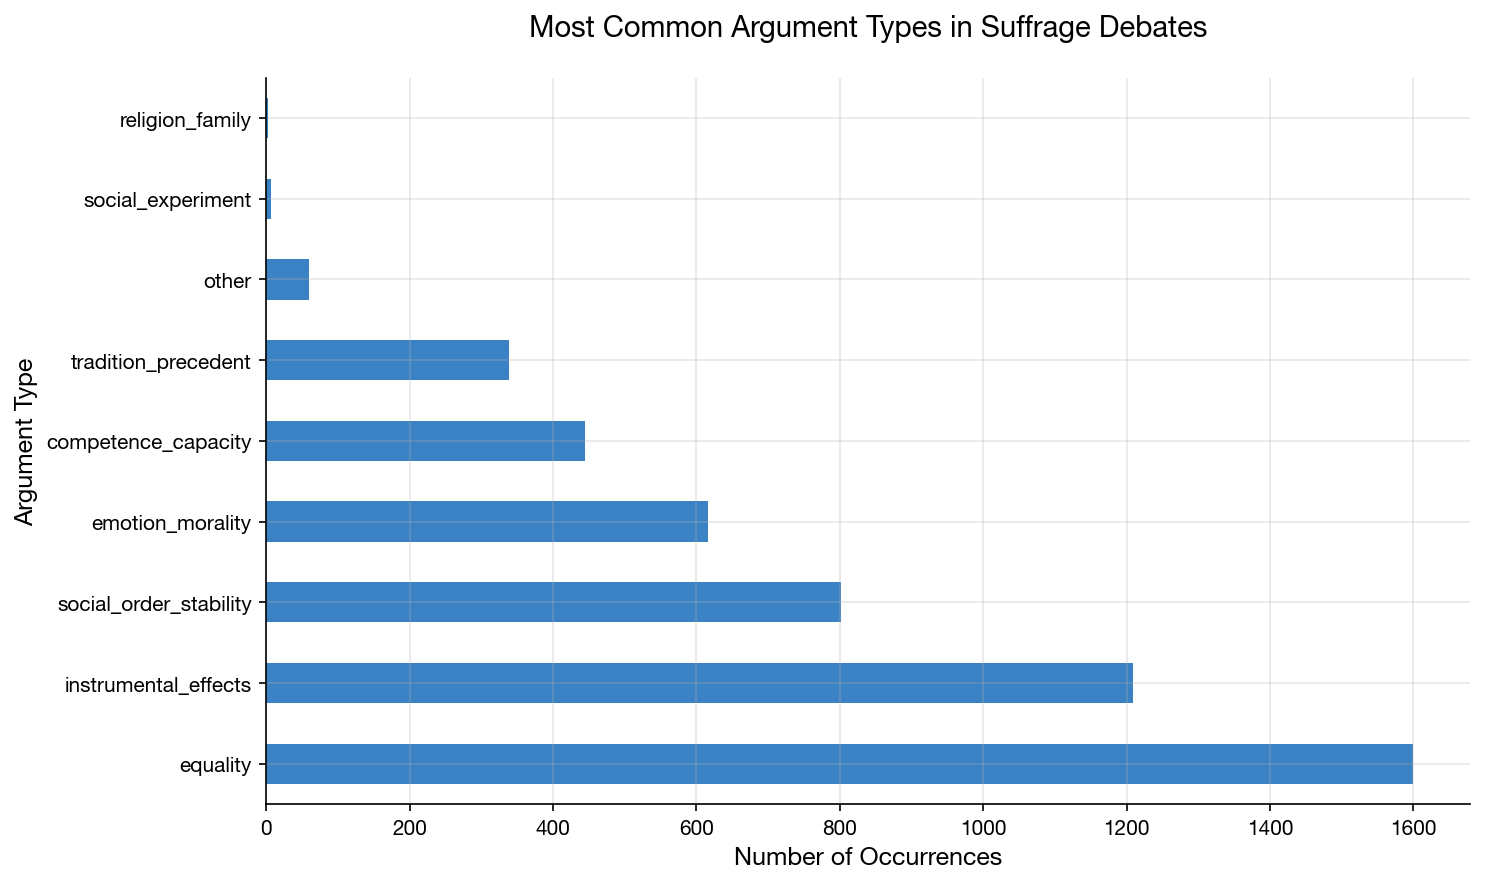

Saved: analysis/suffrage_classification/argument_buckets_overall.png


In [45]:
# Most common argument buckets
bucket_counts = reasons_df['bucket'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

bucket_counts.head(15).plot(kind='barh', ax=ax, color=COLORS['male'])

ax.set_xlabel('Number of Occurrences', fontsize=12, fontweight='bold')
ax.set_ylabel('Argument Type', fontsize=12, fontweight='bold')
ax.set_title('Most Common Argument Types in Suffrage Debates', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'argument_buckets_overall.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "argument_buckets_overall.png"}')

In [ ]:
# Arguments by stance (FOR vs AGAINST)
for_reasons = reasons_df[reasons_df['stance_label'] == 'for']['bucket'].value_counts()
against_reasons = reasons_df[reasons_df['stance_label'] == 'against']['bucket'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# FOR arguments - show top 10, independently sorted
for_top = for_reasons.head(10).sort_values()
for_top.plot(kind='barh', ax=ax1, color=COLORS['for'])
ax1.set_xlabel('Occurrences', fontsize=11, fontweight='bold')
ax1.set_ylabel('Argument Type', fontsize=11, fontweight='bold')
ax1.set_title(f'Arguments FOR Suffrage (n={for_reasons.sum():.0f})', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# AGAINST arguments - show top 10, independently sorted
against_top = against_reasons.head(10).sort_values()
against_top.plot(kind='barh', ax=ax2, color=COLORS['against'])
ax2.set_xlabel('Occurrences', fontsize=11, fontweight='bold')
ax2.set_ylabel('Argument Type', fontsize=11, fontweight='bold')
ax2.set_title(f'Arguments AGAINST Suffrage (n={against_reasons.sum():.0f})', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

fig.suptitle('Top 10 Argument Types by Stance (Independently Sorted)', 
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'arguments_by_stance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "arguments_by_stance.png"}')

## 4. Temporal Evolution of Arguments

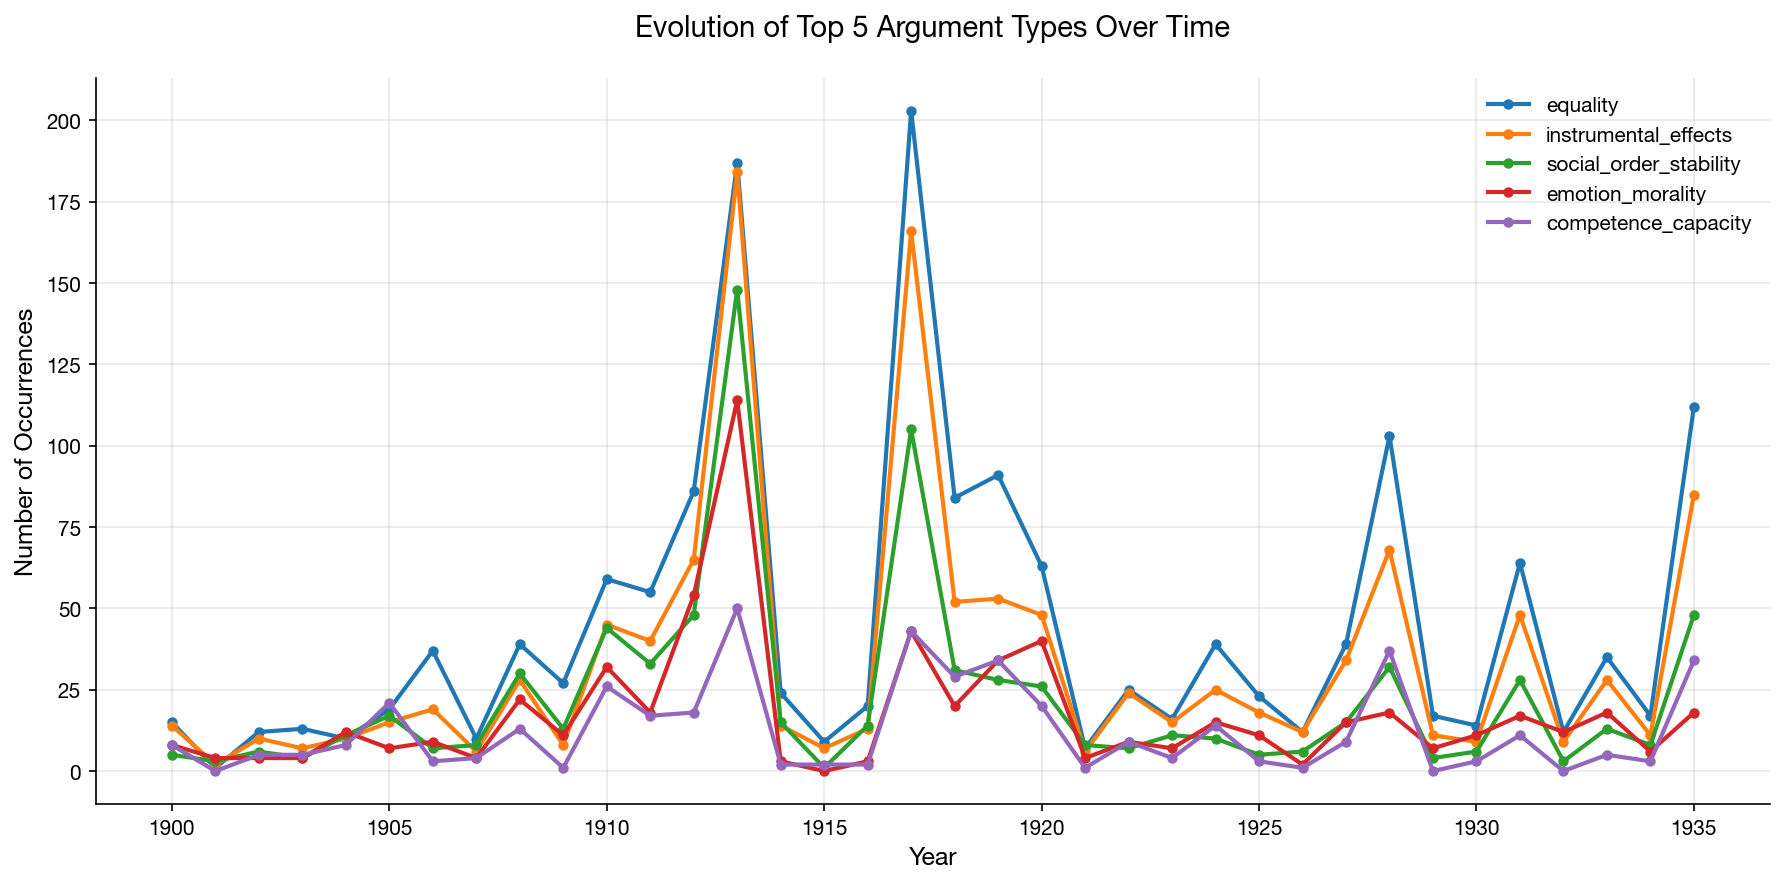

Saved: analysis/suffrage_classification/temporal_argument_evolution.png


In [47]:
# Top 5 argument types over time
top_buckets = bucket_counts.head(5).index.tolist()

temporal_buckets = reasons_df[reasons_df['bucket'].isin(top_buckets)].groupby(['year', 'bucket']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 6))

for bucket in top_buckets:
    if bucket in temporal_buckets.columns:
        ax.plot(temporal_buckets.index, temporal_buckets[bucket], 
                marker='o', linewidth=2, label=bucket, markersize=4)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Occurrences', fontsize=12, fontweight='bold')
ax.set_title('Evolution of Top 5 Argument Types Over Time', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', frameon=False, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'temporal_argument_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "temporal_argument_evolution.png"}')

## 5. Gender Analysis

Compare argument patterns between male and female MPs.

In [48]:
# Gender distribution in dataset
gender_counts = substantive['gender'].value_counts()

print('Gender distribution:')
print(gender_counts)
print(f'\nFemale MPs: {gender_counts.get("F", 0):,} speeches ({gender_counts.get("F", 0) / len(substantive) * 100:.1f}%)')
print(f'Male MPs: {gender_counts.get("M", 0):,} speeches ({gender_counts.get("M", 0) / len(substantive) * 100:.1f}%)')

Gender distribution:
gender
M    1965
F      76
Name: count, dtype: int64

Female MPs: 76 speeches (3.5%)
Male MPs: 1,965 speeches (90.5%)


In [ ]:
# Stance by gender
gender_stance = substantive.groupby(['gender', 'stance']).size().unstack(fill_value=0)
gender_stance_pct = gender_stance.div(gender_stance.sum(axis=1), axis=0) * 100

print('\nStance distribution by gender (%):')
print(gender_stance_pct)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(gender_stance_pct.index))
width = 0.2

offset = -1.5
if 'for' in gender_stance_pct.columns:
    ax.bar(x + offset*width, gender_stance_pct['for'], width, label='For', color=COLORS['for'])
    offset += 1
if 'against' in gender_stance_pct.columns:
    ax.bar(x + offset*width, gender_stance_pct['against'], width, label='Against', color=COLORS['against'])
    offset += 1
if 'both' in gender_stance_pct.columns:
    ax.bar(x + offset*width, gender_stance_pct['both'], width, label='Both', color=COLORS['both'])
    offset += 1
if 'neutral' in gender_stance_pct.columns:
    ax.bar(x + offset*width, gender_stance_pct['neutral'], width, label='Neutral', color=COLORS['neutral'])

ax.set_xlabel('Gender', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Speeches (%)', fontsize=12, fontweight='bold')
ax.set_title('Suffrage Stance by MP Gender', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(['Female' if g == 'F' else 'Male' for g in gender_stance_pct.index])
ax.legend(frameon=False)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stance_by_gender.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "stance_by_gender.png"}')

In [ ]:
# Arguments used by gender
male_reasons = reasons_df[reasons_df['gender'] == 'M']['bucket'].value_counts()
female_reasons = reasons_df[reasons_df['gender'] == 'F']['bucket'].value_counts()

# Normalize by number of speeches
male_reasons_norm = male_reasons / gender_counts.get('M', 1)
female_reasons_norm = female_reasons / gender_counts.get('F', 1)

# Create side-by-side comparison WITHOUT forcing same order
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Female MPs - show top 10, sorted by their values
female_top = female_reasons_norm.head(10).sort_values()
female_top.plot(kind='barh', ax=ax1, color=COLORS['female'])
ax1.set_xlabel('Avg per Speech', fontsize=11, fontweight='bold')
ax1.set_ylabel('Argument Type', fontsize=11, fontweight='bold')
ax1.set_title(f'Female MPs (n={gender_counts.get("F", 0)})', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Male MPs - show top 10, sorted by their values
male_top = male_reasons_norm.head(10).sort_values()
male_top.plot(kind='barh', ax=ax2, color=COLORS['male'])
ax2.set_xlabel('Avg per Speech', fontsize=11, fontweight='bold')
ax2.set_ylabel('Argument Type', fontsize=11, fontweight='bold')
ax2.set_title(f'Male MPs (n={gender_counts.get("M", 0)})', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

fig.suptitle('Top 10 Argument Types by Gender (Normalized, Independently Sorted)', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'arguments_by_gender.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "arguments_by_gender.png"}')

## 6. Confidence Analysis

In [ ]:
# Confidence distribution by stance
fig, ax = plt.subplots(figsize=(10, 6))

# Get all unique confidence values
all_confidences = sorted(substantive['confidence'].unique())
x_pos = np.arange(len(all_confidences))
width = 0.2

for i, stance in enumerate(['for', 'against', 'both', 'neutral']):
    stance_data = substantive[substantive['stance'] == stance]['confidence']
    if len(stance_data) > 0:
        counts = [len(stance_data[stance_data == conf]) for conf in all_confidences]
        ax.bar(x_pos + i*width, counts, width, label=stance.capitalize(), 
               color=COLORS[stance], alpha=0.8, edgecolor='white', linewidth=1)

ax.set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Speeches', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Classification Confidence by Stance', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos + 1.5*width)
ax.set_xticklabels([f'{c:.1f}' for c in all_confidences])
ax.legend(frameon=False)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: {OUTPUT_DIR / "confidence_distribution.png"}')

In [ ]:
# Average confidence by argument type
bucket_confidence = reasons_df.merge(
    substantive[['speech_id', 'confidence']], 
    on='speech_id'
).groupby('bucket')['confidence'].agg(['mean', 'count', 'std'])

# Filter to buckets with at least 20 occurrences
bucket_confidence = bucket_confidence[bucket_confidence['count'] >= 20].sort_values('mean')

fig, ax = plt.subplots(figsize=(10, 8))

# Bar chart with count labels
bars = ax.barh(range(len(bucket_confidence)), bucket_confidence['mean'], 
               color=COLORS['male'], alpha=0.8, edgecolor='white', linewidth=1)

# Add count labels
for i, (idx, row) in enumerate(bucket_confidence.iterrows()):
    ax.text(row['mean'] + 0.01, i, f"n={int(row['count'])}", 
            va='center', fontsize=9, color='gray')

ax.set_yticks(range(len(bucket_confidence)))
ax.set_yticklabels(bucket_confidence.index)
ax.set_xlabel('Average Confidence Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Argument Type', fontsize=12, fontweight='bold')
ax.set_title('Classification Confidence by Argument Type (n>=20)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

x_min = max(0, bucket_confidence['mean'].min() - 0.05)
x_max = min(1, bucket_confidence['mean'].max() + 0.1)
ax.set_xlim(x_min, x_max)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confidence_by_argument.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\nSaved: {OUTPUT_DIR / "confidence_by_argument.png"}')

## 7. Summary Statistics

In [ ]:
print('='*60)
print('SUFFRAGE CLASSIFICATION ANALYSIS SUMMARY')
print('='*60)

print(f'\nTotal speeches classified: {len(df):,}')
print(f'Substantive speeches (for/against/both/neutral): {len(substantive):,} ({len(substantive)/len(df)*100:.1f}%)')
print(f'Irrelevant speeches: {len(df[df["stance"]=="irrelevant"]):,} ({len(df[df["stance"]=="irrelevant"])/len(df)*100:.1f}%)')

print(f'\nStance breakdown:')
for stance in ['for', 'against', 'both', 'neutral']:
    count = len(substantive[substantive['stance'] == stance])
    pct = count / len(substantive) * 100
    print(f'  {stance.capitalize()}: {count:,} ({pct:.1f}%)')

print(f'\nGender breakdown:')
for gender in ['M', 'F']:
    count = len(substantive[substantive['gender'] == gender])
    pct = count / len(substantive) * 100
    label = 'Male' if gender == 'M' else 'Female'
    print(f'  {label}: {count:,} ({pct:.1f}%)')

print(f'\nTemporal coverage:')
print(f'  Years: {df["year"].min():.0f} - {df["year"].max():.0f}')
print(f'  Span: {df["year"].max() - df["year"].min():.0f} years')

print(f'\nArgument analysis:')
print(f'  Total reasons extracted: {len(reasons_df):,}')
print(f'  Average per speech: {len(reasons_df) / len(substantive):.2f}')
print(f'  Unique argument types: {reasons_df["bucket"].nunique()}')

print(f'\nTop 5 argument types:')
for i, (bucket, count) in enumerate(bucket_counts.head(5).items(), 1):
    print(f'  {i}. {bucket}: {count:,} ({count/len(reasons_df)*100:.1f}%)')

print(f'\nConfidence statistics:')
print(f'  Mean: {substantive["confidence"].mean():.3f}')
print(f'  Median: {substantive["confidence"].median():.3f}')
print(f'  Std dev: {substantive["confidence"].std():.3f}')

print(f'\nOutputs saved to: {OUTPUT_DIR}')
print('='*60)

## 8. Export Key Results

In [ ]:
# Save summary statistics as CSV
summary_stats = {
    'total_speeches': len(df),
    'substantive_speeches': len(substantive),
    'irrelevant_speeches': len(df[df['stance'] == 'irrelevant']),
    'for_count': len(substantive[substantive['stance'] == 'for']),
    'against_count': len(substantive[substantive['stance'] == 'against']),
    'both_count': len(substantive[substantive['stance'] == 'both']),
    'neutral_count': len(substantive[substantive['stance'] == 'neutral']),
    'male_count': len(substantive[substantive['gender'] == 'M']),
    'female_count': len(substantive[substantive['gender'] == 'F']),
    'year_min': df['year'].min(),
    'year_max': df['year'].max(),
    'total_reasons': len(reasons_df),
    'avg_reasons_per_speech': len(reasons_df) / len(substantive),
    'unique_argument_types': reasons_df['bucket'].nunique(),
    'mean_confidence': substantive['confidence'].mean(),
    'median_confidence': substantive['confidence'].median(),
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv(OUTPUT_DIR / 'summary_statistics.csv', index=False)

print(f'Saved: {OUTPUT_DIR / "summary_statistics.csv"}')

# Save reasons dataset for further analysis
reasons_df.to_csv(OUTPUT_DIR / 'extracted_reasons.csv', index=False)
print(f'Saved: {OUTPUT_DIR / "extracted_reasons.csv"}')

print('\nAnalysis complete!')